In [1]:
import os
import yaml
import json
import torch
from PIL import Image
from src import (
    get_model_and_tokenizer,
    CustomTrainingArgs,
    ModelArguments,
    VLMTrainingArguments,
    VLMCollator
)
import torchvision.transforms as T
from PIL import Image
from visual import EVAVisionTransformer
from visual import EVAVisionConfig
import torch
import json
from typing import List
import os
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import List, Dict, Optional, Tuple
from safetensors.torch import save_file, load_file
import matplotlib.pyplot as plt

vision_config = EVAVisionConfig()
visual_model = EVAVisionTransformer(
    img_size=vision_config.image_size,
    patch_size=vision_config.patch_size,
    embed_dim=vision_config.width,
    depth=vision_config.layers,
    num_heads=vision_config.width // vision_config.head_width,
    mlp_ratio=vision_config.mlp_ratio,
    qkv_bias=vision_config.qkv_bias,
    drop_path_rate=vision_config.drop_path_rate,
    xattn=vision_config.xattn,
    postnorm=vision_config.postnorm,
)
state_dict = load_file("./visual/visual_model.safetensors")
visual_model.load_state_dict(state_dict)
visual_model = visual_model.eval().half().to("cuda")

c:\Users\28296\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\28296\AppData\Local\Programs\Python\Python312\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'


In [2]:
training_args, custom_training_args, model_args = CustomTrainingArgs(), VLMTrainingArguments(), ModelArguments()    
for key, value in vars(custom_training_args).items():
    setattr(training_args, key, value)
model_args_path = model_args.model_config_path
additional_tokens_path =  model_args.special_token_config
flashattention = False
with open(model_args_path, 'r') as f:
    model_args = yaml.load(f, Loader=yaml.FullLoader)
if flashattention:
    model_args['flashattention'] = flashattention
with open(additional_tokens_path, 'r') as f:
    added_tokens = json.load(f)
additional_tokens_dict = {x['type']: x['token'] for x in added_tokens['added_tokens']}

In [3]:
model_args['pretrained_model'] = "results/checkpoint-4000"

In [4]:

model, tokenizer, special_token_map = get_model_and_tokenizer(model_args, additional_tokens_dict)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_token_id = tokenizer.eos_token_id
device = "cuda"
model = model.to(torch.float16).to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
collate_fn = VLMCollator(tokenizer, 196, special_token_map=special_token_map, num_patches=64)

In [6]:
def generate_with_cache(
    model,
    past_key_values,
    input_ids: torch.Tensor,
    eos_id: int,
    max_length: int = 196,
    temperature: float = 0.8,
    top_p: float = 0.7,
) -> Tuple[torch.Tensor, List[int]]:
    
    # Initialize generation variables
    batch_size = input_ids.shape[0]
    current_length = input_ids.shape[1]
    generated_tokens = []
    
    # Track which sequences have finished
    finished_sequences = torch.zeros(batch_size, dtype=torch.bool, device=input_ids.device)
    
    # Generation loop
    while current_length < max_length and not finished_sequences.all():
        # Forward pass with caching
        with torch.no_grad():
            outputs = model._native_forward(
                input_ids if past_key_values is None else input_ids[:, -1:],
                attention_mask=None,
                position_ids=None,
                labels=None,
                past_key_values=past_key_values,
                use_cache=True,
            )
            
            # Get logits and update cache
            next_token_logits = outputs.logits[:, -1, :]
            past_key_values = outputs.past_key_values
            
            # Apply temperature
            scaled_logits = next_token_logits / temperature
            
            # Apply softmax to get probabilities
            probs = torch.nn.functional.softmax(scaled_logits, dim=-1)
            
            # Apply top-p (nucleus) sampling
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            
            # Zero out filtered logits
            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            probs[indices_to_remove] = 0
            
            # For finished sequences, force EOS token by zeroing out all other probabilities
            probs[finished_sequences] = 0
            probs[finished_sequences, eos_id] = 1
            
            # Sample next token
            if current_length != 25:
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                next_token = torch.tensor([[50256], [50255]], device=probs.device)
            
            # Mask tokens with EOS for finished sequences
            next_token = torch.where(finished_sequences.unsqueeze(1), 
                                   torch.tensor(eos_id, device=next_token.device),
                                   next_token)
            
            # Update finished sequences mask
            finished_sequences = finished_sequences | (next_token.squeeze(-1) == eos_id)
            
            # Store generated tokens
            generated_tokens.append(next_token.clone())
            
            # Update input_ids for next iteration
            input_ids = torch.cat([input_ids, next_token], dim=-1)
            current_length += 1
            
            # If all sequences are finished, break early
            if finished_sequences.all():
                break
    
    # Stack all generated tokens
    all_tokens = torch.cat(generated_tokens, dim=1)
    
    return all_tokens

In [7]:
class ImageProcessor():
    def __init__(self, visual_model, image_size, device):
        self.visual_model = visual_model
        self.device = device
        self.image_size = image_size
        OPENAI_DATASET_MEAN = (0.48145466, 0.4578275, 0.40821073)
        OPENAI_DATASET_STD = (0.26862954, 0.26130258, 0.27577711)
        self.transform = T.Compose([
            T.Resize((image_size, image_size), interpolation=T.InterpolationMode.BICUBIC),
            T.ToTensor(),
            T.Normalize(OPENAI_DATASET_MEAN, OPENAI_DATASET_STD),
        ])
        image = Image.open("reference.jpg")
        image = self.transform(image).unsqueeze(0).to("cuda").to(torch.float16)
        visual_model.set_reference_embedding(image)
        self.aspect_ratio_threshold = 0.6
        self.crop_transforms = [
            T.Resize(image_size, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(image_size),
        ]
        
    def resize_and_pad(self, img):
        """
        Resize image based on longest side and pad with black
        """
        width, height = img.size
        
        # Calculate scaling factor based on longest side
        longest_side = max(width, height)
        scale = self.image_size / longest_side
        
        # Calculate new dimensions maintaining aspect ratio
        new_width = int(width * scale)
        new_height = int(height * scale)
        
        # Resize image
        img = img.resize((new_width, new_height), Image.Resampling.BICUBIC)
        
        # Create new square image with black background
        new_img = Image.new('RGB', (self.image_size, self.image_size), (0, 0, 0))
        
        # Calculate paste position to center the image
        paste_x = (self.image_size - new_width) // 2
        paste_y = (self.image_size - new_height) // 2
        
        # Paste resized image onto black background
        new_img.paste(img, (paste_x, paste_y))
        
        return new_img

    def preprocess_image(self, img):
        """
        Adaptively choose preprocessing method based on aspect ratio
        """
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        width, height = img.size
        aspect_ratio = min(width, height) / max(width, height)
        
        # Track which method was used
        if aspect_ratio >= self.aspect_ratio_threshold:
            # Use center crop for images with good aspect ratio
            for transform in self.crop_transforms:
                img = transform(img)
        else:
            # Use padding for images with extreme aspect ratios
            img = self.resize_and_pad(img)
        
        return img

    @torch.no_grad()
    def encode_image(self, img):
        opened_image = Image.open(img)
        image = self.preprocess_image(opened_image)
        image = self.transform(image).unsqueeze(0).to(self.device).half()
        features, similarity = self.visual_model.encode_image_w_similarity(image)
        return features.squeeze(0), "random_caption", "random_source"

In [8]:
processor = ImageProcessor(visual_model, 448, "cuda")

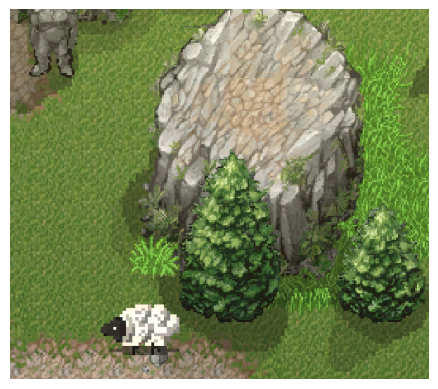



The screenshot depicts a sheep standing in front of a group of trees.<|eot_id|>


In [13]:
image_path = "test.png"
encoded = processor.encode_image(image_path)
batch = collate_fn([encoded])
eval_input_ids = batch['eval_input_ids'].to(device)
# Prepare KV cache
past_key_values = model.prepare_for_generation(
    eval_input_ids[:, :-1], 
    batch['encoded_image'].to(device)
)
# Generate captions
generated_ids = generate_with_cache(model, past_key_values, eval_input_ids, tokenizer.eos_token_id)
caption = tokenizer.decode(generated_ids[0])
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()
print(caption)

Below code generate caption for first 100 rows of training set.

In [10]:
# captions = []
# images = []
# for i in range(100):
#     batch = collate_fn([train_dataset[i]])
#     eval_input_ids = batch['eval_input_ids'].to(device)
#     # Prepare KV cache
#     past_key_values = model.prepare_for_generation(
#         eval_input_ids[:, :-1], 
#         batch['encoded_image'].to(device)
#     )

#     # Generate captions
#     generated_ids = generate_with_cache(model, past_key_values, eval_input_ids, tokenizer.eos_token_id)
#     caption = tokenizer.decode(generated_ids[0])
#     captions.append(caption)
#     image_path = batch['image'][0]
#     images.append(Image.open(image_path))

In [11]:
# show_image = 1
# print(captions[show_image])
# plt.imshow(images[show_image])
# plt.axis('off')
# plt.show()